In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings


warnings.filterwarnings("ignore")
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    recall_score,
    make_scorer,
    classification_report,
    accuracy_score,
    precision_score,
    f1_score,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
)
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict


from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from scipy.stats import randint, uniform

In [4]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 30)

### Read The DataSet

---


In [5]:
# Reading the data
df = pd.read_csv(
    "project_data.csv",
)

### Simple EDA (Mostly Checking Column Names, NaN's, Value Counts, Spread, Variance)

---


In [6]:
df.head()

,Unnamed: 0,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,NaN,1.0,1,Returning_Visitor,False,False
1,1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2.0,NaN,2,Returning_Visitor,False,False
2,2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1.0,NaN,3,Returning_Visitor,False,False
3,3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2.0,2.0,4,Returning_Visitor,False,False
4,4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3.0,1.0,4,Returning_Visitor,True,False


In [7]:
# Removing a duplicate index column
df = df.drop(columns="Unnamed: 0")

In [8]:
# Checking For NaN's And Datatypes For Each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12207 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12146 non-null  float64
 13  Region                   12084 non-null  float64
 14  TrafficType           

In [9]:
# Checking NaN's per column
df.isnull().sum()

Administrative               0
Administrative_Duration      0
Informational                0
Informational_Duration       0
ProductRelated               0
ProductRelated_Duration      0
BounceRates                  0
ExitRates                    0
PageValues                   0
SpecialDay                 123
Month                        0
OperatingSystems             0
Browser                    184
Region                     246
TrafficType                  0
VisitorType                  0
Weekend                      0
Revenue                    147
dtype: int64

In [10]:
# Checking Regular Information
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.238200,3.409269,-10.00000,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,1269.776004,34071.466930,0.00000,0.000000,8.000000,93.787500,989493.000000
Informational,12330.0,0.503569,1.270156,0.00000,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.00000,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.00000,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.00000,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.044239,0.239735,-0.49868,0.000000,0.002896,0.018029,2.098952
ExitRates,12330.0,0.043073,0.048597,0.00000,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.00000,0.000000,0.000000,0.000000,361.763742
SpecialDay,12207.0,0.061260,0.198650,0.00000,0.000000,0.000000,0.000000,1.000000


**_Some Thoughts From The Above Information_**

- **Revenue Has Nan's - Must Be Dropped (However, We Can Predict Those For Fun Later On If We Have A Good Model That We Trust)**
- **Administrative Has Negative Values - Shouldnt Be Possible**
- **Administrative_Duration Has Some Extreme Values - Must Be Looked Into**
- **BounceRates Has Negative Values Aswell - Shouldnt Be Possible**
- **Special Day, Browser, Region And Month Has Nan's - We Either Need To Drop Those Rows, Whole Column Or Impute Values. Will Do Some Deeper Analyis And Decide Later**
- **ProductRelated_Duration Has Some Extreme Values - Must Be Looked Into**
- ***


**_Removing NaN Rows From Our Target Column For Now. If We Can Create A Good Model Later On I Might Do My Predictions On It To Simulate "Unseen Data"_**


In [11]:
# Removing Any Rows Where Our Target Column Has A NAN
df.dropna(subset=["Revenue"], inplace=True)

In [12]:
# Changing The Revenue Column To Have 1 For True And 0 For False
df["Revenue"] = df["Revenue"].replace({True: 1, False: 0})

In [13]:
# Saving Names Of All Columns That Are Of Data Type Object
categorical_cols = df.select_dtypes("object").columns.tolist()

In [14]:
# Printing Value Counts For All The Categorical Non Numerical Columns
for column in categorical_cols:
    print(f"{df[column].value_counts()}\n")

Month
May     3155
Nov     2962
Mar     1886
Dec     1708
Oct      545
Aug      427
Jul      426
Sep      353
June     285
Feb      181
Turc     168
Sept      87
Name: count, dtype: int64

VisitorType
Returning_Visitor    10424
New_Visitor           1675
Other                   84
Name: count, dtype: int64

Weekend
False        9166
True         2833
Name:Zara     184
Name: count, dtype: int64



**_Changing Sep To Sept(Most Likely That This Was A Mistake When Creating The Abbreviation)  
I Also Changed Turc To April Since That Was Also A Month Missing, Not Sure If The Original Data Had This In It But I Decided That This Was The Better Approach, We Are However Still Lacking Data For January. Let's Try To Figure Out If This Column Is Important For Our Model Later On And If Not, We Can Maybe Drop It._**


In [15]:
# Changing Sep To Sept And Turc To April. Ive Understood From Some Researching That January Is not Always Included In Theese Kinds Of Data!
df["Month"] = df["Month"].replace("Turc", "April")
df["Month"] = df["Month"].replace("Sep", "Sept")

In [16]:
# Checking That We Have All The Months From Feb - Dec
df["Month"].value_counts()

Month
May      3155
Nov      2962
Mar      1886
Dec      1708
Oct       545
Sept      440
Aug       427
Jul       426
June      285
Feb       181
April     168
Name: count, dtype: int64

In [17]:
# Saving Numerical Columns Names
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
# After Reading The Docs, We Should'nt Have Any Negative Numbers So I Change The Ones We had To Positive Since They Were In Normal Range For Their Columns
df[numeric_cols] = df[numeric_cols].abs()

In [18]:
px.scatter(df, df["Administrative_Duration"])

**_From This Plot We Can See That We Have Some Really Big Outliers In The Administrative Duration Column That We Need To Deal With_**


In [19]:
# Checking If We Had A Duration Of Admin Pages That Were 0 But The Duration For The Same Pages Were Higher Than 0
df.query("Administrative == 0 and Administrative_Duration > 0")

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
6434,0,971707.0,0,0.0,9,249.410000,0.022222,0.005128,0.0,0.0,Nov,1,2.0,1.0,4,Returning_Visitor,False,0
8641,0,965480.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Dec,3,2.0,7.0,1,Returning_Visitor,False,0
8979,0,984643.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Nov,1,1.0,1.0,1,Other,False,0
9375,0,985147.0,0,0.0,42,2239.363889,0.020000,0.035455,0.0,0.0,Dec,3,2.0,7.0,2,Returning_Visitor,False,0
9948,0,973917.0,0,0.0,3,0.000000,0.200000,0.200000,0.0,0.0,Nov,2,7.0,2.0,1,Returning_Visitor,False,0


In [20]:
# Changing The Values Here To 0 Since if A Session Didnt Visit An Administrative Page Couldnt Have A Duration For Those Pages
df.loc[df["Administrative"] == 0, "Administrative_Duration"] = 0

In [21]:
# Checking If We Had A Duration Of Product Related Pages That Were 0 But The Duration For The Same Pages Were Higher Than 0
df.query("ProductRelated == 0 and ProductRelated_Duration > 0")

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue


In [22]:
# Checking If We Had A Duration Of Informational Related Pages That Were 0 But The Duration For The Same Pages Were Higher Than 0
df.query("Informational == 0 and Informational_Duration > 0")

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue


In [23]:
# Identifying The Outliers From Administrative_Duration Since Theese Rows Had Values Reaching Close To 1 Million While The Rest Had Values < 3500!
rows_to_drop = df.query("Administrative_Duration > 3500").index

# Dropping These Rows From The DataFrame
df = df.drop(index=rows_to_drop)

In [24]:
# Changing Values From Weekend Column Which Didnt Belong There To NaN So That I Can Impute Them Later Or Drop The Column All Together
df["Weekend"] = df["Weekend"].replace({"Name:Zara": np.nan, "True": 1, "False": 0})

---


In [25]:
df.isna().sum()

Administrative               0
Administrative_Duration      0
Informational                0
Informational_Duration       0
ProductRelated               0
ProductRelated_Duration      0
BounceRates                  0
ExitRates                    0
PageValues                   0
SpecialDay                 121
Month                        0
OperatingSystems             0
Browser                    182
Region                     244
TrafficType                  0
VisitorType                  0
Weekend                    184
Revenue                      0
dtype: int64

In [26]:
# Changing Values In Special Day To Numerical.
df["SpecialDay"] = df["SpecialDay"].replace({"True": 1, "False": 0})

In [27]:
df_corr = df.corr(numeric_only=True)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=df_corr.columns,
        y=df_corr.index,
        z=df_corr,
        text=df_corr.values,
        texttemplate="%{text:.2f}",
    )
)
fig.show()

**_Just By Looking At The Correlation Plot Above, I Already Want To Feature Engineer The Columns In The Group To The Bottom Left Of The Plot_**


In [28]:
df.query("PageValues > 0 and Revenue == False").sort_values(
    by="PageValues", ascending=False
)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5773,4,158.200000,0,0.000000,62,4402.250000,0.000000,0.001042,246.758590,0.0,Oct,4,1.0,8.0,2,New_Visitor,0.0,0
8345,2,123.750000,0,0.000000,21,938.333333,0.010000,0.016667,218.395192,0.0,Dec,1,1.0,3.0,2,Returning_Visitor,0.0,0
10640,22,1153.682251,3,108.000000,205,4295.305066,0.001747,0.008801,177.528825,0.0,Nov,2,5.0,3.0,3,Returning_Visitor,1.0,0
6429,2,64.400000,0,0.000000,15,443.566667,0.000000,0.006250,166.373553,0.0,June,1,1.0,1.0,5,New_Visitor,1.0,0
7938,5,143.442857,1,19.600000,184,3579.785900,0.000000,0.003819,138.320834,0.0,Oct,2,2.0,3.0,20,Returning_Visitor,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5917,15,169.033333,0,0.000000,223,2477.536550,0.000000,0.003694,0.179827,0.0,Oct,2,2.0,7.0,3,Returning_Visitor,1.0,0
6559,8,85.482234,1,5.500000,227,3818.308629,0.007265,0.018863,0.154821,0.0,Oct,2,2.0,1.0,13,Returning_Visitor,0.0,0
6684,20,199.456273,7,299.033333,686,23342.082050,0.009853,0.022771,0.150650,0.0,Aug,2,2.0,1.0,1,Returning_Visitor,0.0,0
6030,12,187.775000,0,0.000000,98,2138.481263,0.001887,0.017985,0.129677,0.0,Jul,2,5.0,3.0,2,Returning_Visitor,1.0,0


In [29]:
fig = px.histogram(
    df,
    x="Month",
    title=f"Distribution of Months",
    color="Month",
)
fig.update_layout(bargap=0.1)
fig.show()

In [30]:
px.scatter(
    df,
    "ProductRelated_Duration",
    color="Revenue",
)

In [31]:
px.scatter(df, "Administrative_Duration", color="Revenue")

In [32]:
px.scatter(df, "PageValues", color="Revenue")

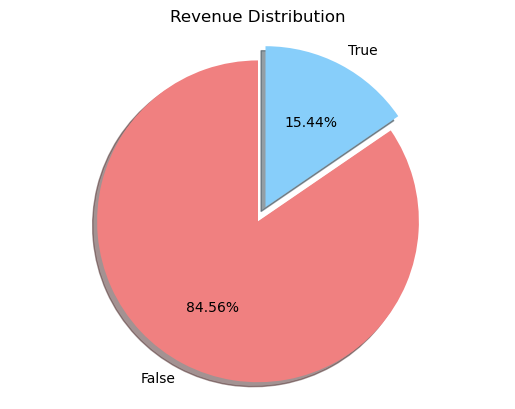

In [33]:
revenue_df = df["Revenue"].value_counts().reset_index()
revenue_df.columns = ["Revenue", "Count"]
revenue_df["Revenue"] = revenue_df["Revenue"].replace({0: False, 1: True})


sizes = revenue_df["Count"].values


labels = ["False", "True"]

labels = labels
sizes = sizes
colors = ["lightcoral", "lightskyblue"]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct="%1.2f%%",
    shadow=True,
    startangle=90,
)
ax1.axis("equal")

plt.title("Revenue Distribution")
plt.show()

In [34]:
special_day_revenue_df = (
    df.groupby("SpecialDay")["Revenue"]
    .value_counts(normalize=True)
    .unstack()
    .reset_index()
)
special_day_revenue_df.columns = ["SpecialDay", "Revenue_False", "Revenue_True"]
special_day_revenue_df.sort_values(by="Revenue_True", ascending=True).reset_index(
    drop=True
)

,SpecialDay,Revenue_False,Revenue_True
0,0.8,0.965732,0.034268
1,0.4,0.949580,0.050420
2,1.0,0.933333,0.066667
3,0.2,0.925287,0.074713
4,0.6,0.917889,0.082111
5,0.0,0.835150,0.164850


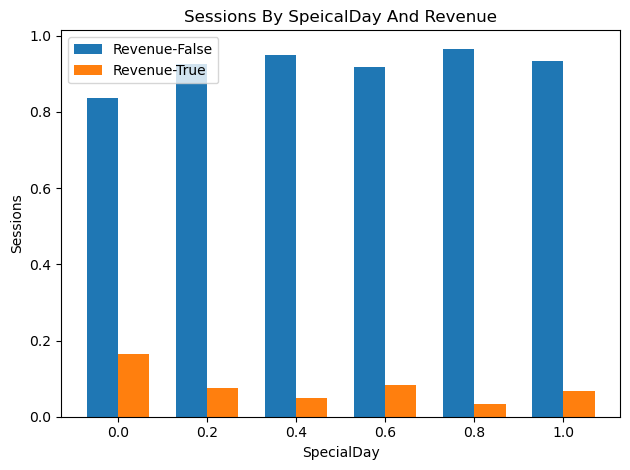

In [35]:
special_day = special_day_revenue_df["SpecialDay"]
revenue_false = special_day_revenue_df["Revenue_False"]
revenue_true = special_day_revenue_df["Revenue_True"]

x = np.arange(len(special_day))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, revenue_false, width, label="Revenue-False")
rects2 = ax.bar(x + width / 2, revenue_true, width, label="Revenue-True")


ax.set_ylabel("Sessions")
ax.set_xlabel("SpecialDay")
ax.set_title("Sessions By SpeicalDay And Revenue")
ax.set_xticks(x)
ax.set_xticklabels(special_day)
ax.legend()

fig.tight_layout()

plt.show()

In [36]:
monthly_revenue = (
    df.groupby("Month")["Revenue"].value_counts(normalize=True).unstack().reset_index()
)
monthly_revenue.columns = ["Month", "Revenue_False", "Revenue_True"]
monthly_revenue.sort_values(by="Revenue_True", ascending=False).reset_index(drop=True)

,Month,Revenue_False,Revenue_True
0,Nov,0.746622,0.253378
1,Oct,0.790055,0.209945
2,Sept,0.806378,0.193622
3,Aug,0.826291,0.173709
4,Jul,0.849412,0.150588
5,Dec,0.875220,0.124780
6,April,0.886905,0.113095
7,May,0.891532,0.108468
8,Mar,0.900318,0.099682
9,June,0.901754,0.098246


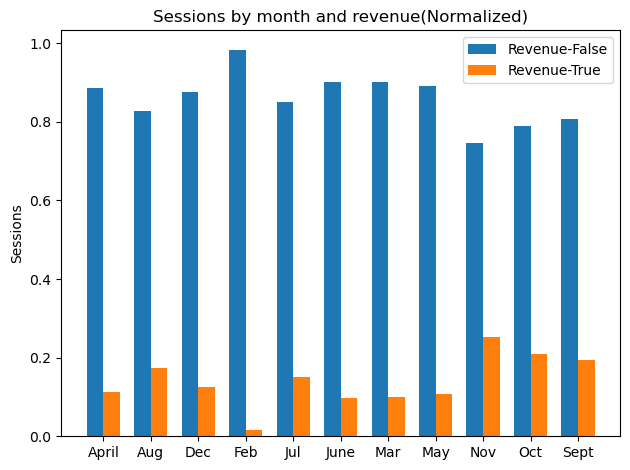

In [37]:
months = monthly_revenue["Month"]
revenue_false = monthly_revenue["Revenue_False"]
revenue_true = monthly_revenue["Revenue_True"]

x = np.arange(len(months))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, revenue_false, width, label="Revenue-False")
rects2 = ax.bar(x + width / 2, revenue_true, width, label="Revenue-True")


ax.set_ylabel("Sessions")
ax.set_title("Sessions by month and revenue(Normalized)")
ax.set_xticks(x)
ax.set_xticklabels(months)
ax.legend()

fig.tight_layout()

plt.show()

In [38]:
weekend_revenue_df = (
    df.groupby("Weekend")["Revenue"]
    .value_counts(normalize=True)
    .unstack()
    .reset_index()
)
weekend_revenue_df.columns = ["Weekend", "Revenue_False", "Revenue_True"]
weekend_revenue_df.sort_values(by="Revenue_True", ascending=True).reset_index(drop=True)

,Weekend,Revenue_False,Revenue_True
0,0.0,0.852511,0.147489
1,1.0,0.825380,0.174620


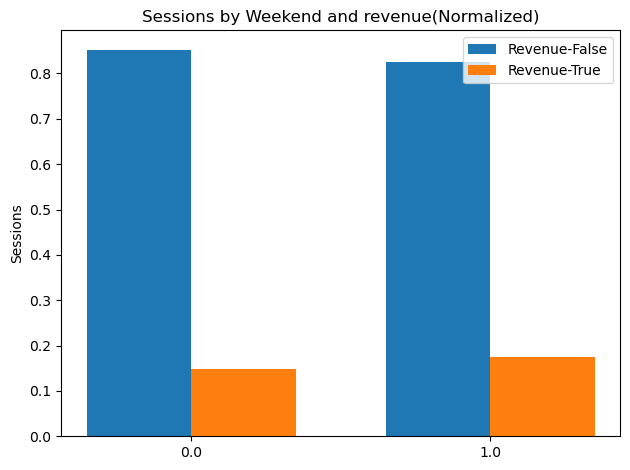

In [39]:
weekend = weekend_revenue_df["Weekend"]
revenue_false = weekend_revenue_df["Revenue_False"]
revenue_true = weekend_revenue_df["Revenue_True"]

x = np.arange(len(weekend))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, revenue_false, width, label="Revenue-False")
rects2 = ax.bar(x + width / 2, revenue_true, width, label="Revenue-True")


ax.set_ylabel("Sessions")
ax.set_title("Sessions by Weekend and revenue(Normalized)")
ax.set_xticks(x)
ax.set_xticklabels(weekend)
ax.legend()

fig.tight_layout()

plt.show()

In [40]:
region_revenue = (
    df.groupby("Region")["Revenue"].value_counts(normalize=True).unstack().reset_index()
)
region_revenue.columns = ["Region", "Revenue_False", "Revenue_True"]
region_revenue.sort_values(by="Revenue_True", ascending=False).reset_index(drop=True)

,Region,Revenue_False,Revenue_True
0,9.0,0.832998,0.167002
1,2.0,0.835753,0.164247
2,5.0,0.836538,0.163462
3,1.0,0.839043,0.160957
4,7.0,0.840000,0.160000
5,4.0,0.850877,0.149123
6,3.0,0.853247,0.146753
7,6.0,0.864103,0.135897
8,8.0,0.869668,0.130332


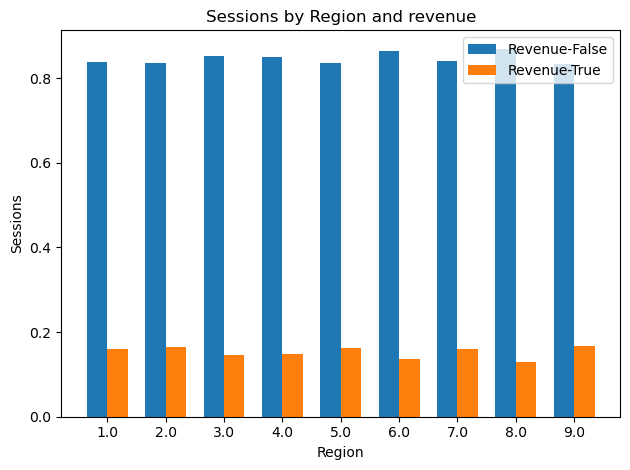

In [41]:
region = region_revenue["Region"]
revenue_false = region_revenue["Revenue_False"]
revenue_true = region_revenue["Revenue_True"]

x = np.arange(len(region))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, revenue_false, width, label="Revenue-False")
rects2 = ax.bar(x + width / 2, revenue_true, width, label="Revenue-True")


ax.set_ylabel("Sessions")
ax.set_xlabel("Region")
ax.set_title("Sessions by Region and revenue")
ax.set_xticks(x)
ax.set_xticklabels(region)
ax.legend()

fig.tight_layout()

plt.show()

In [42]:
Browser_revenue = (
    df.groupby("Browser")["Revenue"]
    .value_counts(normalize=False)
    .unstack()
    .reset_index()
)
Browser_revenue.columns = ["Browser", "Revenue_False", "Revenue_True"]
Browser_revenue.sort_values(by="Revenue_True", ascending=False).reset_index(drop=True)

,Browser,Revenue_False,Revenue_True
0,2.0,6558.0,1188.0
1,1.0,2035.0,354.0
2,4.0,585.0,127.0
3,5.0,372.0,85.0
4,10.0,129.0,28.0
5,6.0,150.0,20.0
6,8.0,112.0,20.0
7,13.0,45.0,16.0
8,7.0,43.0,6.0
9,3.0,96.0,5.0


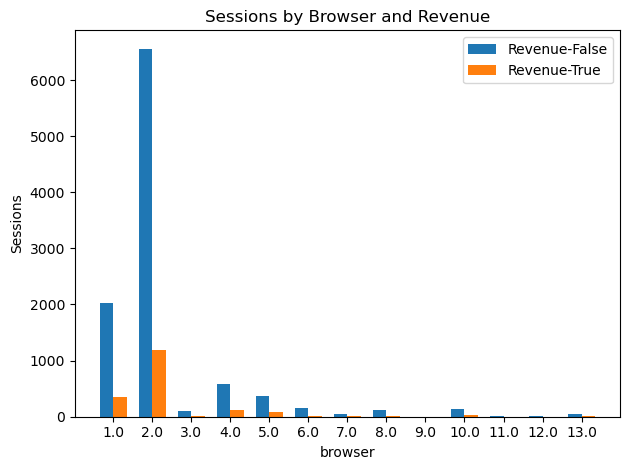

In [43]:
browser = Browser_revenue["Browser"]
revenue_false = Browser_revenue["Revenue_False"]
revenue_true = Browser_revenue["Revenue_True"]

x = np.arange(len(browser))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, revenue_false, width, label="Revenue-False")
rects2 = ax.bar(x + width / 2, revenue_true, width, label="Revenue-True")


ax.set_ylabel("Sessions")
ax.set_xlabel("browser")
ax.set_title("Sessions by Browser and Revenue")
ax.set_xticks(x)
ax.set_xticklabels(browser)
ax.legend()

fig.tight_layout()

plt.show()

In [44]:
# Checking The Rows Where BounceRates Are More Than 1, We cant Have A Higher BounceRate Than 100%.
df.query("BounceRates > 1")

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
10,0,0.000000,0,0.00,3,395.000000,1.767990,0.066667,0.000000,0.0,Feb,1,1.0,3.0,3,Returning_Visitor,0.0,0
55,0,0.000000,0,0.00,1,0.000000,1.250573,0.200000,0.000000,0.2,Feb,2,4.0,1.0,3,Returning_Visitor,0.0,0
56,0,0.000000,0,0.00,1,0.000000,2.057441,0.200000,0.000000,0.6,Feb,3,2.0,3.0,3,Returning_Visitor,0.0,0
136,0,0.000000,0,0.00,9,303.666667,1.274479,0.046296,0.000000,0.0,Feb,2,4.0,5.0,2,Returning_Visitor,0.0,0
159,0,0.000000,0,0.00,1,0.000000,1.298691,0.200000,0.000000,0.0,Feb,3,2.0,3.0,3,Returning_Visitor,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12101,1,21.250000,1,0.00,23,1171.071429,1.203863,0.039506,11.077032,0.0,Dec,2,2.0,7.0,1,Returning_Visitor,0.0,0
12128,6,77.750000,0,0.00,18,941.916667,1.826557,0.001429,0.000000,0.0,Nov,2,2.0,1.0,2,New_Visitor,0.0,0
12200,0,0.000000,0,0.00,1,0.000000,1.867932,0.200000,0.000000,0.0,Dec,2,2.0,6.0,1,Returning_Visitor,1.0,0
12214,0,0.000000,0,0.00,69,2077.806007,1.271865,0.018562,0.000000,0.0,Nov,2,2.0,4.0,2,Returning_Visitor,0.0,0


In [45]:
# Dividing The Above Rows With 100 To Change Them Into Decimal Form
df.loc[df["BounceRates"] > 1, "BounceRates"] = df["BounceRates"] / 100

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12173.0,2.349298,3.334988,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12173.0,80.714721,176.780366,0.0,0.000000,7.000000,93.000000,3398.750000
Informational,12173.0,0.503081,1.267504,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12173.0,34.420989,140.914888,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12173.0,31.701881,44.456366,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12173.0,1193.415480,1914.927849,0.0,184.100000,598.500000,1462.659125,63973.522230
BounceRates,12173.0,0.030286,0.069991,0.0,0.000000,0.004167,0.019355,0.498680
ExitRates,12173.0,0.043158,0.048696,0.0,0.014286,0.025185,0.050000,0.200000
PageValues,12173.0,5.881998,18.528410,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12052.0,0.061517,0.199083,0.0,0.000000,0.000000,0.000000,1.000000


In [47]:
df.isnull().sum()

Administrative               0
Administrative_Duration      0
Informational                0
Informational_Duration       0
ProductRelated               0
ProductRelated_Duration      0
BounceRates                  0
ExitRates                    0
PageValues                   0
SpecialDay                 121
Month                        0
OperatingSystems             0
Browser                    182
Region                     244
TrafficType                  0
VisitorType                  0
Weekend                    184
Revenue                      0
dtype: int64

---

### Feature Engineering

- **_TotalPages - All Type Of Pages Added Together_**
- **_TotalDuration - All Durations Added Together_**
- **_Duration_Per_Page - TotalDuration / TotalPages_**
- **_Duration_Per_Product - ProductRelated_Duration / ProductRelated_**

**_I Think That Theese Might Give Me A Better Insight Into What Actually Matters For Revenue Later On_**


In [48]:
df.insert(
    6,
    "TotalPages",
    df["Administrative"] + df["Informational"] + df["ProductRelated"],
)

In [49]:
df.insert(
    7,
    "TotalDuration",
    df["Administrative_Duration"]
    + df["Informational_Duration"]
    + df["ProductRelated_Duration"],
)

In [50]:
df.insert(8, "Duration_Per_Page", df["TotalDuration"] / df["TotalPages"])

In [51]:
df.insert(
    9,
    "PageValue_per_ProductRelated",
    ((df["PageValues"] / df["TotalPages"]) * df["ProductRelated"]),
)

In [52]:
df.insert(
    10,
    "Duration_Per_Product_Page",
    df["ProductRelated_Duration"] / df["ProductRelated"],
)

In [53]:
# Filling In The Newly Created NaN's With 0's
df["PageValue_per_ProductRelated"] = df["PageValue_per_ProductRelated"].fillna(0)


df["Duration_Per_Product_Page"] = df["Duration_Per_Product_Page"].fillna(0)


df["Duration_Per_Page"] = df["Duration_Per_Page"].fillna(0)

---

**_Saving All Categorical Columns To A Variable, Even The Ones That Are Numerical Now_**


In [54]:
categorical_cols

['Month', 'VisitorType', 'Weekend']

In [55]:
numeric_cols

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'Revenue']

In [56]:
df["TotalPages"].value_counts()

TotalPages
1      583
2      399
3      357
5      349
8      347
      ... 
201      1
228      1
258      1
526      1
255      1
Name: count, Length: 313, dtype: int64

In [57]:
categorical_numerical_cols = [
    "SpecialDay",
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType",
    "Weekend",
]

In [58]:
categorical_cols = categorical_cols + categorical_numerical_cols

In [59]:
categorical_cols

['Month',
 'VisitorType',
 'Weekend',
 'SpecialDay',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'Weekend']

In [60]:
categorical_cols.pop()  # Removing Weekend Once, Since That Appears Twice

'Weekend'

---

### Splitting Our Data Into Train/Validation/Test

**_Also Making Sure We Split Before We Make Any Imputation, Encoding Or Anything Else That Might Cause Data Leakage_**


In [61]:
X, y = df.drop(columns=["Revenue"]), df[["Revenue"]]

---

**_Saving All Numeric Non Categorical Columns In A list For Scaling Etc..  
Also Adding Our New Columns To The Numerical Columns List We Created Early On_**


In [62]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
numeric_non_categorical_cols = [
    col for col in numeric_cols if col not in categorical_cols
]
numeric_non_categorical_cols

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'TotalPages',
 'TotalDuration',
 'Duration_Per_Page',
 'PageValue_per_ProductRelated',
 'Duration_Per_Product_Page',
 'BounceRates',
 'ExitRates',
 'PageValues']

**_Splitting Our Data Into Train/Val/Test, We Add Stratify Parameter To Make Sure That Our Distribution Of The Target Is Equal Among All Sets Since The Data Is Imbalanced._**  
**_We Will Handle The Imbalance In The Training Set With Different Techniques To See What Works Best_**


In [63]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, train_size=0.2, stratify=y, random_state=42
)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=42
)

---

## Imputing NaN's With The Most Frequent Value Of Each Column

**_I couldnt Find Any Correlations That Could Help Us Find A Solution That Is Alot Better, So For This Exercise, This Will Have To Do_**


In [65]:
cols_to_impute = [
    "SpecialDay",
    "Browser",
    "Region",
    "Weekend",
]

In [66]:
imputer = SimpleImputer(strategy="most_frequent").fit(X_train[cols_to_impute])

In [67]:
X_train[cols_to_impute] = imputer.transform(X_train[cols_to_impute])
X_val[cols_to_impute] = imputer.transform(X_val[cols_to_impute])
X_test[cols_to_impute] = imputer.transform(X_test[cols_to_impute])

In [68]:
X_train.isna().sum()

Administrative                  0
Administrative_Duration         0
Informational                   0
Informational_Duration          0
ProductRelated                  0
ProductRelated_Duration         0
TotalPages                      0
TotalDuration                   0
Duration_Per_Page               0
PageValue_per_ProductRelated    0
Duration_Per_Product_Page       0
BounceRates                     0
ExitRates                       0
PageValues                      0
SpecialDay                      0
Month                           0
OperatingSystems                0
Browser                         0
Region                          0
TrafficType                     0
VisitorType                     0
Weekend                         0
dtype: int64

---

# OneHotEncoding Our Categorical Columns Since Some Models Do Not Handle Certain Categorical Columns Well


In [69]:
X_train.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'TotalPages', 'TotalDuration', 'Duration_Per_Page',
       'PageValue_per_ProductRelated', 'Duration_Per_Product_Page',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object')

In [70]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore").fit(
    X_train[categorical_cols]
)

encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [71]:
X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_val[encoded_cols] = encoder.transform(X_val[categorical_cols])
X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])

---

### Scaling Our Numerical(Non Categorical) Columns Since Some Models Work Better This Way

**_We Will Use A Robust Scaler Since It's Less Sensitive To Outliers Compared To A StandardScaler And Because Our Features Are Not Normally Distributed_**


In [72]:
scaler = RobustScaler().fit(X_train[numeric_non_categorical_cols])

In [73]:
X_train[numeric_non_categorical_cols] = scaler.transform(
    X_train[numeric_non_categorical_cols]
)
X_val[numeric_non_categorical_cols] = scaler.transform(
    X_val[numeric_non_categorical_cols]
)
X_test[numeric_non_categorical_cols] = scaler.transform(
    X_test[numeric_non_categorical_cols]
)

---

### Saving Our Changes To The Df Without The Columns That We Encoded


In [74]:
X_train = X_train[numeric_non_categorical_cols + encoded_cols]
X_val = X_val[numeric_non_categorical_cols + encoded_cols]
X_test = X_test[numeric_non_categorical_cols + encoded_cols]

---  
***I Wanted To Implement An Sklearn Pipeline Where I Had My Imputer, Scaler, Encoder And Model But Realized This Caused All Kind Of Issues When Trying To Get All Features Out Especially When Using Libraries Like EBM, Shap And Lime. So We Will Instead Do It The Way That We have Practiced In Class***  

---


**_Since We Have An Imbalance In Our Targets, We Will Try Different Methods To Handle This:_**

- Adding The Class Weight Parameter
- Undersampling
- Oversampling
- Smotesampling
- Do Nothing At All


### Creating Our First Models

- LinearRegressor
- DecisionTree
- RandomForest
- SVM
- KNN
- AdaBoost
- EBM

---


**_Let's Start By Not Handling The Imbalance And Try Our Models Out Of The Box(OOTB)_**


In [75]:
def evaluate_model_performance(
    X, y, models, scoring, cv_strategy=StratifiedKFold(n_splits=5)
):
    """
    Parameters:
    - X: Features dataset
    - y: Target dataset
    - models: Dictionary of model names and their corresponding initialized objects
    - scoring: Dictionary of scoring metrics
    - cv_strategy: Cross-validation splitting strategy

    Returns:
    A dictionary containing cross-validated performance metrics for each model.
    """
    model_performance = {}
    for name, model in models.items():
        cv_results = cross_validate(
            model, X, y, cv=cv_strategy, scoring=scoring, n_jobs=-1
        )

        # Store the mean of the scores from the cross-validation
        model_performance[name] = {
            "Accuracy": np.mean(cv_results["test_accuracy"]),
            "Precision": np.mean(cv_results["test_precision"]),
            "Recall": np.mean(cv_results["test_recall"]),
            "F1 Score": np.mean(cv_results["test_f1_score"]),
        }

    return model_performance

In [76]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Explainable Boosting": ExplainableBoostingClassifier(random_state=42),
}

In [77]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, zero_division=0, pos_label=1),
    "recall": make_scorer(recall_score, zero_division=0, pos_label=1),
    "f1_score": make_scorer(f1_score, zero_division=0, pos_label=1),
}

In [78]:
model_performance_ootb = evaluate_model_performance(
    X_train.values, y_train, models, scoring
)

# Display the performance
for model, performance in model_performance_ootb.items():
    print(f"{model}:")
    for metric, value in performance.items():
        print(f"  {metric}: {value:.4f}")
    print()

Logistic Regression:
  Accuracy: 0.8855
  Precision: 0.7253
  Recall: 0.4216
  F1 Score: 0.5302

Decision Tree:
  Accuracy: 0.8632
  Precision: 0.5593
  Recall: 0.5475
  F1 Score: 0.5529

Random Forest:
  Accuracy: 0.9072
  Precision: 0.7736
  Recall: 0.5667
  F1 Score: 0.6536

SVC:
  Accuracy: 0.8902
  Precision: 0.7747
  Recall: 0.4067
  F1 Score: 0.5326

KNN:
  Accuracy: 0.8925
  Precision: 0.6897
  Recall: 0.5510
  F1 Score: 0.6120

AdaBoost:
  Accuracy: 0.8878
  Precision: 0.6606
  Recall: 0.5628
  F1 Score: 0.6067

Explainable Boosting:
  Accuracy: 0.9002
  Precision: 0.7154
  Recall: 0.5890
  F1 Score: 0.6452



**_We Can see That For All The Models We Get Good Accuracy, But Accuracy Isn't The Best Metric For Imbalanced Data.  
Precision Looks Decent But Far From Good And Recall Looks Really Bad All Over_**

**_Let's Try To Add The "Class Weight" Parameter To Our Models And See If We Can See Any Improvements!(KNN, AdaBoost And EBM Does Not Have This So They Will Be Excluded For Now)_**


In [80]:
cw_models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "SVC": SVC(class_weight="balanced", random_state=42),
}

In [81]:
class_weight_model_performance = evaluate_model_performance(
    X_train, y_train, cw_models, scoring
)

# Display the performance
for model, performance in class_weight_model_performance.items():
    print(f"{model}:")
    for metric, value in performance.items():
        print(f"  {metric}: {value:.4f}")
    print()

Logistic Regression:
  Accuracy: 0.8591
  Precision: 0.5329
  Recall: 0.7716
  F1 Score: 0.6290

Decision Tree:
  Accuracy: 0.8667
  Precision: 0.5765
  Recall: 0.5475
  F1 Score: 0.5598

Random Forest:
  Accuracy: 0.8949
  Precision: 0.7216
  Recall: 0.5211
  F1 Score: 0.6038

SVC:
  Accuracy: 0.8620
  Precision: 0.5422
  Recall: 0.6956
  F1 Score: 0.6086



**_What's Interesting Now Is That Some Models Have Much Better Recall And Worse Precison Compared To Before. Now All Of A Sudden LogisticRegression Has The Best F1 SCore Out OF Theese Models, Also, RandomForest Seem To Be Performing Way Worse Now_**

**_I Was Thinking About Using Other Sampling Methods To Deal With Class Imbalance, But One Issue With That Is That When Doing A Crossvalidation, The "Test Folds" Will Oversampled, Undersampled, Or Smoted, Which Wont Be An Actual Representation Of How A Test Set Would Be. So I Decided To Just Use Models That Are Good At Handling THe Imbalance By Themselves_**

---

### Models I Will Be Using:

- **_AdaBoost_**
- **_RandomForest_**
- **_ExplainableBoostingMachine_**


In [82]:
models_to_use = [
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    ExplainableBoostingClassifier(random_state=42),
]

In [269]:
def search_best_parameters(model, param_grid, X_train, y_train, cv=3, n_iter=100):
    search = RandomizedSearchCV(
        model,
        param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring="f1",
        random_state=42,
        verbose=3,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)

    print(f"Best parameters for {model.__class__.__name__}: {search.best_params_}")
    print(f"Best score for {model.__class__.__name__}: {search.best_score_}")
    return search.best_params_, search.best_score_

In [270]:
param_grids = [
    {
        "n_estimators": randint(100, 500),
        "max_depth": randint(3, 15),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(2, 4),
        "max_features": [
            "sqrt",
            "log2",
        ],
    },
    {  # AdaBoost Parameters
        "n_estimators": randint(50, 400),
        "learning_rate": uniform(0.01, 1.0),
    },
    {  # ExplainableBoosting Parameters
        "learning_rate": uniform(0.01, 0.1),
        "max_bins": randint(200, 300),
        "max_interaction_bins": randint(10, 20),
        "interactions": randint(5, 15),
        "min_samples_leaf": randint(2, 10),
    },
]

In [84]:
best_params = {}


best_scores = {}


for model, param_grid in zip(models_to_use, param_grids):

    best_params, best_score = search_best_parameters(
        model, param_grid, X_train, y_train, n_iter=30
    )

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for RandomForestClassifier: {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 363}
Best score for RandomForestClassifier: 0.6453150677370166
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for AdaBoostClassifier: {'learning_rate': 0.06808361216819946, 'n_estimators': 137}
Best score for AdaBoostClassifier: 0.6319362533092185
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for ExplainableBoostingClassifier: {'interactions': 9, 'learning_rate': 0.034929222914887495, 'max_bins': 214, 'max_interaction_bins': 13, 'min_samples_leaf': 6}
Best score for ExplainableBoostingClassifier: 0.6312996347354778


In [83]:
adaboost_tuned = AdaBoostClassifier(
    learning_rate=0.068,
    n_estimators=137,
    random_state=42,
).fit(X_train, y_train)

In [84]:
adaboost_val_preds = adaboost_tuned.predict(X_val)

In [85]:
print(classification_report(y_val, adaboost_val_preds))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       618
           1       0.73      0.50      0.60       113

    accuracy                           0.89       731
   macro avg       0.82      0.74      0.77       731
weighted avg       0.89      0.89      0.89       731



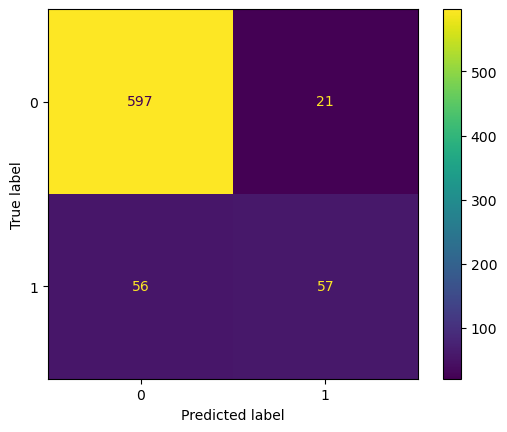

In [86]:
cm = confusion_matrix(y_val, adaboost_val_preds, labels=adaboost_tuned.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=adaboost_tuned.classes_
)
disp.plot()
plt.show()

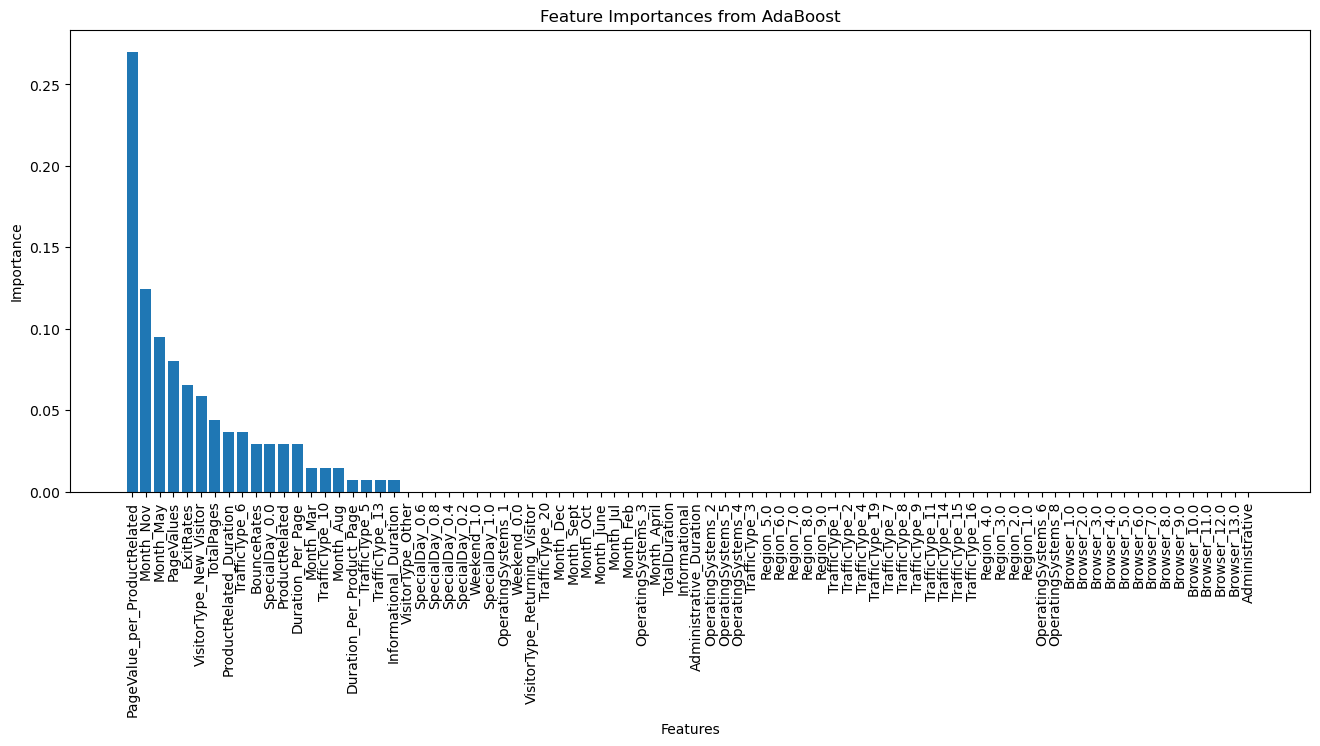

In [87]:
# Assuming your model is named `adaboost_tuned` and is already fitted
feature_importances = adaboost_tuned.feature_importances_

# Get feature names from the DataFrame, assuming `X_train` is a DataFrame
feature_names = X_train.columns

# Sorting the feature importances with their corresponding feature names
indices = np.argsort(feature_importances)[
    ::-1
]  # Sort the feature indices by importance
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

# Plotting
plt.figure(figsize=(16, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align="center")
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances from AdaBoost")
plt.show()

**_It Seems Like THe Model Has Decided That Only A Very Select Few To Be Important, If The Other Models Look The Same Then We Will Drop The PageValues Columns Since We Want The Model To Learn From Different Features And Behaviors_**


---


In [88]:
ebm_tuned = ExplainableBoostingClassifier(
    random_state=42,
    interactions=9,
    learning_rate=0.034,
    max_bins=214,
    max_interaction_bins=13,
    min_samples_leaf=6,
).fit(X_train, y_train)

In [89]:
ebm_tuned_preds = ebm_tuned.predict(X_val)

In [90]:
print(classification_report(y_val, ebm_tuned_preds))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       618
           1       0.75      0.51      0.61       113

    accuracy                           0.90       731
   macro avg       0.83      0.74      0.78       731
weighted avg       0.89      0.90      0.89       731



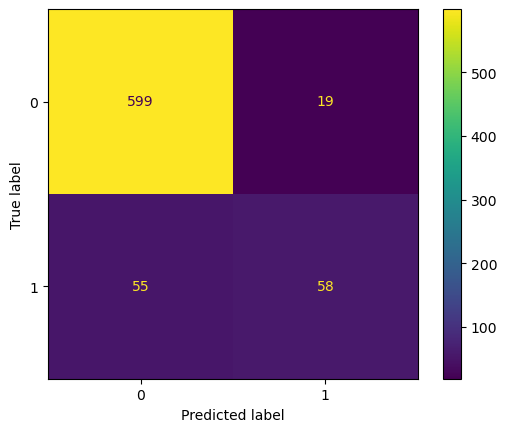

In [91]:
cm = confusion_matrix(y_val, ebm_tuned_preds, labels=ebm_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ebm_tuned.classes_)
disp.plot()
plt.show()

In [92]:
randomforest_tuned = RandomForestClassifier(
    random_state=42,
    max_depth=14,
    max_features="sqrt",
    min_samples_leaf=3,
    min_samples_split=6,
    n_estimators=363,
).fit(X_train, y_train)

In [93]:
randomforest_tuned_preds = randomforest_tuned.predict(X_val)

In [94]:
print(classification_report(y_val, randomforest_tuned_preds))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       618
           1       0.77      0.52      0.62       113

    accuracy                           0.90       731
   macro avg       0.84      0.75      0.78       731
weighted avg       0.89      0.90      0.89       731



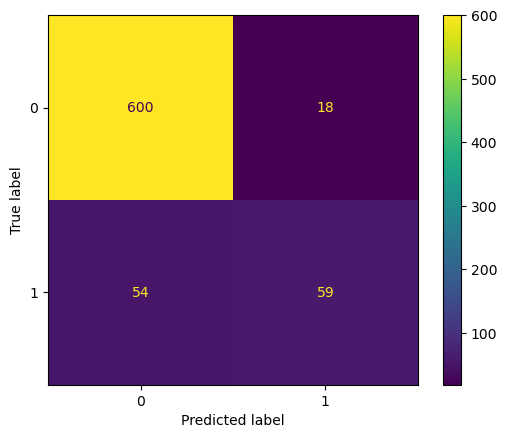

In [95]:
cm = confusion_matrix(
    y_val, randomforest_tuned_preds, labels=randomforest_tuned.classes_
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=randomforest_tuned.classes_
)
disp.plot()
plt.show()

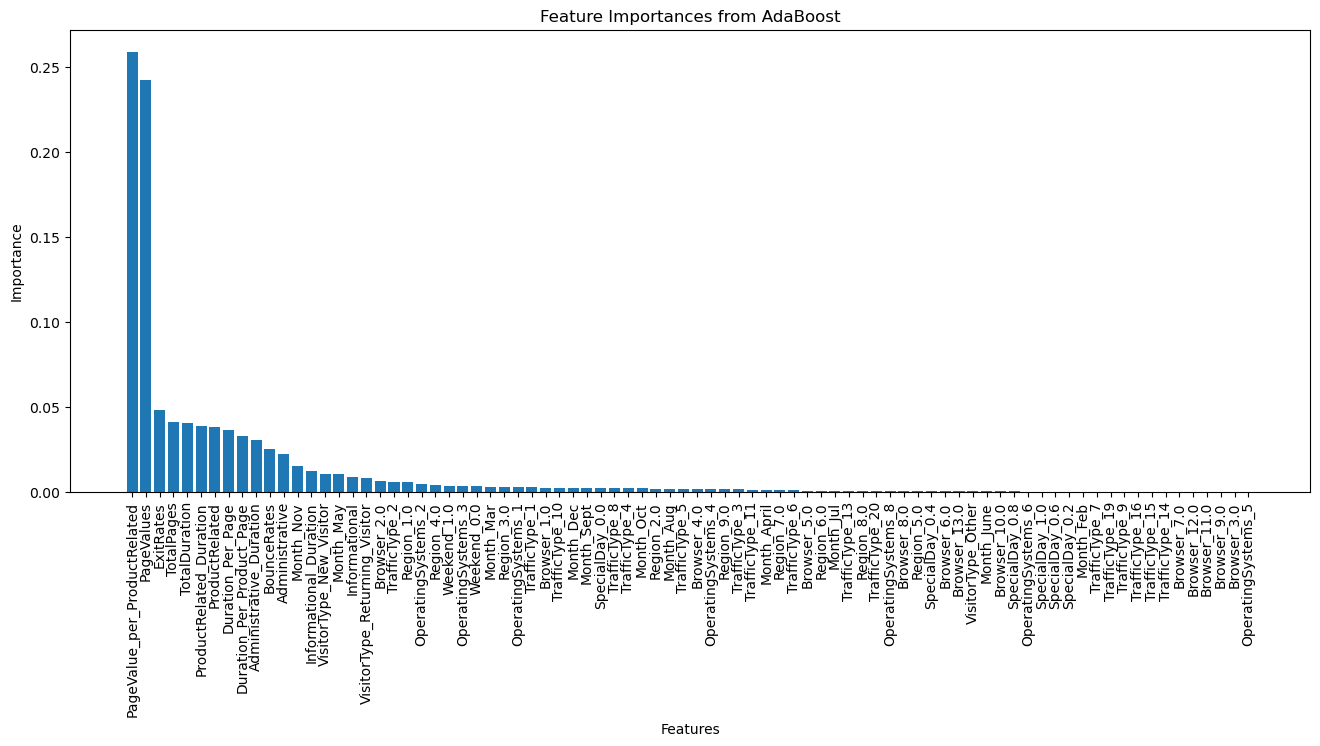

In [96]:
# Assuming your model is named `randomforest_tuned` and is already fitted
feature_importances = randomforest_tuned.feature_importances_

# Get feature names from the DataFrame, assuming `X_train` is a DataFrame
feature_names = X_train.columns

# Sorting the feature importances with their corresponding feature names
indices = np.argsort(feature_importances)[
    ::-1
]  # Sort the feature indices by importance
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

# Plotting
plt.figure(figsize=(16, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align="center")
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances from AdaBoost")
plt.show()

**_Here We Can See That More Features Seem To Matter, Even If PageValues Related Features Are Still Very High. Let's Look At EBM If Thats The Same_**


---


In [97]:
global_explanation = ebm_tuned.explain_global()

show(global_explanation)

<!-- http://127.0.0.1:7001/2565374008464/ -->

In [95]:
show(ebm_tuned.explain_local(X_val[11:20], y_val[11:20]), 0)

<!-- http://127.0.0.1:7001/1897849933584/ -->

In [96]:
show(ebm_tuned.explain_local(X_val[50:70], y_val[50:70]), 0)

<!-- http://127.0.0.1:7001/1897867067088/ -->

**_Here We can See THat More Features Matter, We Can Also See That The Intercept is Negative With Alot Which Is Too Be Expected Since 85% Of Our Data Belongs To Class 0_**
**_Another Thing To Notice Is How A Feature Like Browser_7 Gets Such A High Negative Weight. This Happens Because We Didnt Have Many Samples With This Value So Most Likely The Model Is Giving Them Too Much Of An Importance. Same Thing Has Happened For A Few Other Features. Lets Try And Reduce The Dimensions And See What Performance We Get_**

---

**_We Will Use RFECV(Recursive feature elimination with cross-validation) From SkLearn To Get The Best Amount And Best Features To Use._**


In [101]:
feature_selector = RFECV(
    estimator=randomforest_tuned,
    step=1,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    min_features_to_select=1,
    n_jobs=-1,
)

In [102]:
feature_selector.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_depth=14, min_samples_leaf=3,
                                       min_samples_split=6, n_estimators=363,
                                       random_state=42),
      n_jobs=-1, scoring='f1')

In [103]:
print(f"Optimal number of features: {feature_selector.n_features_}")
print(f"Ranking of features: {feature_selector.ranking_}")

Optimal number of features: 36
Ranking of features: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 14  5  1 34 19 24  1  1  1  6
  1  1 28  1  1  1  1 30 25 32 29 33  1  1  1 11 47 36 18  2  1 38  1 16
 26 39 21 43 31 42 41 27  1  8  1  1 20 15 13 23 10  1  1  4  1  7  9 35
  3 37  1 12 17 44 40 45 46 22]


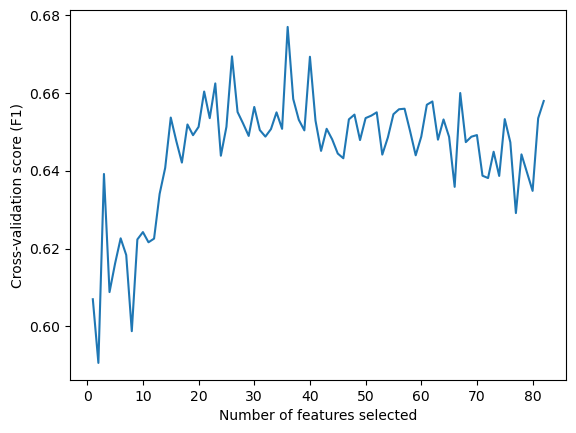

In [104]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (F1)")

# Extract the number of features and the corresponding mean test scores
number_of_features = list(
    range(1, len(feature_selector.cv_results_["mean_test_score"]) + 1)
)
mean_test_scores = feature_selector.cv_results_["mean_test_score"]

plt.plot(number_of_features, mean_test_scores)
plt.show()

**_As We Can See From The Above Plot, The Best F1 Score Is Given When Using Just Above 35 Features. We Will Drop The Features That Wasnt Selected And Train Our Models Again. 36 Features Is Better Than 80+ Features Since It Makes Our Model Alot Easier To Understand And Easier To Explain!_**


In [105]:
ranking = feature_selector.ranking_
# Get the selected features (True means selected)
selected = feature_selector.support_


# Get the feature names
feature_names = list(X_train.columns)

# Map the rankings and selected features to the feature names
ranked_features = sorted(zip(feature_names, ranking, selected), key=lambda x: x[1])

# Now selecting the 36 selected features from the ranked list
top_36_features = [feature for feature, rank, is_selected in ranked_features[:36]]

36

In [110]:
# Saving A Train Set With Our Selected Features Only
X_train_reduced = X_train[top_36_features]

In [111]:
# Doing THe Same For Our Validation Set
X_val_reduced = X_val[top_36_features]

---

**_Doing A New Hyperparameter Tuning On The Reduced Dataset And Then Training The Models With The New parameters._**


In [110]:
param_grids = [
    {  # RandomFOrest Parameters
        "n_estimators": randint(100, 500),
        "max_depth": randint(1, 12),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(2, 6),
        "max_features": [
            "sqrt",
            "log2",
        ],
    },
    {  # AdaBoost Parameters
        "n_estimators": randint(50, 400),
        "learning_rate": uniform(0.01, 1.0),
    },
    {  # ExplainableBoosting Parameters
        "learning_rate": uniform(0.01, 0.1),
        "max_bins": randint(200, 300),
        "max_interaction_bins": randint(10, 20),
        "interactions": randint(5, 15),
        "min_samples_leaf": randint(2, 10),
    },
]
best_params = {}


best_scores = {}


for model, param_grid in zip(models_to_use, param_grids):

    best_params, best_score = search_best_parameters(
        model, param_grid, X_train_reduced, y_train, n_iter=20
    )
    print()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for RandomForestClassifier: {'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 364}
Best score for RandomForestClassifier: 0.657051282051282

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for AdaBoostClassifier: {'learning_rate': 0.1006064345328208, 'n_estimators': 100}
Best score for AdaBoostClassifier: 0.6379683777344596

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for ExplainableBoostingClassifier: {'interactions': 12, 'learning_rate': 0.04337086111390219, 'max_bins': 223, 'max_interaction_bins': 12, 'min_samples_leaf': 7}
Best score for ExplainableBoostingClassifier: 0.6482899552120528



In [112]:
randomforest_reduced_tuned = RandomForestClassifier(
    random_state=42,
    max_depth=9,
    max_features="log2",
    min_samples_leaf=3,
    min_samples_split=3,
    n_estimators=364,
).fit(X_train_reduced, y_train)


ebm_reduced_tuned = ExplainableBoostingClassifier(
    random_state=42,
    interactions=12,
    learning_rate=0.043,
    max_bins=223,
    max_interaction_bins=12,
    min_samples_leaf=7,
).fit(X_train_reduced, y_train)


adaboost_reduced_tuned = AdaBoostClassifier(
    random_state=42, learning_rate=0.1006064345328208, n_estimators=100
).fit(X_train_reduced, y_train)

---

**_Testing Our Models On Our Validation Set_**


In [113]:
randomforest_reduced_preds = randomforest_reduced_tuned.predict(X_val_reduced)
ebm_reduced_preds = ebm_reduced_tuned.predict(X_val_reduced)
adaboost_reduced_preds = adaboost_reduced_tuned.predict(X_val_reduced)

### Evaluating On Our Validation Set


In [115]:
print("Classification Report For RandomForest")
print()
print(classification_report(y_val, randomforest_reduced_preds))

Classification Report For RandomForest

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       618
           1       0.77      0.52      0.62       113

    accuracy                           0.90       731
   macro avg       0.84      0.75      0.78       731
weighted avg       0.89      0.90      0.89       731



---


In [116]:
print("Classification Report For ExplainableBoostingMachine")
print()
print(classification_report(y_val, ebm_reduced_preds))

Classification Report For ExplainableBoostingMachine

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       618
           1       0.75      0.57      0.65       113

    accuracy                           0.90       731
   macro avg       0.84      0.77      0.80       731
weighted avg       0.90      0.90      0.90       731



---


In [ ]:
print("Classification Report For AdaBoost")
print()
print(classification_report(y_val, adaboost_reduced_preds))

Classification Report For AdaBoost

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       618
           1       0.71      0.50      0.59       113

    accuracy                           0.89       731
   macro avg       0.81      0.73      0.76       731
weighted avg       0.88      0.89      0.88       731



---

**_All 3 Of Our Models Have Precision Over 70% While Recall Is A Bit Lower. Our EBM Model Is The One That Performed Best Overall So We will Go Ahead With That And Try To Optimize It A Little Bit Further By Testing New Thresholds._**


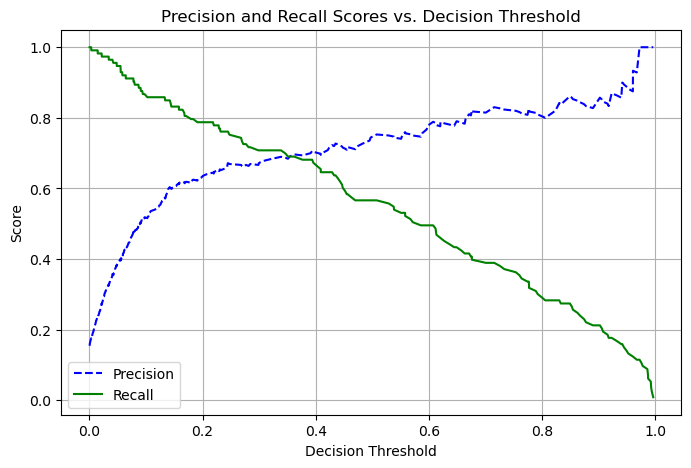

In [117]:
y_scores = ebm_reduced_tuned.predict_proba(X_val_reduced)[:, 1]

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

# Plot precision and recall as functions of the threshold value
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.title("Precision and Recall Scores vs. Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

**_From The Plot Above It's Clear That We Get The Highest Precision And Recall Together When THe Threshold Is Around 0.3. This Could Be Because It's Easy For Our Model To Predict Class 0 And More Difficult To Be Confindent When It's Class 1. This Means In This Case, That We Can Lower Our Threshold And Still Get CLass 0 Correct While Also Getting More Class 1 Predictions Correct. Let's Plot The Acacuracy On This Plot ASwell And Then Get The Threshold Where Precision And Recall Intersect_**


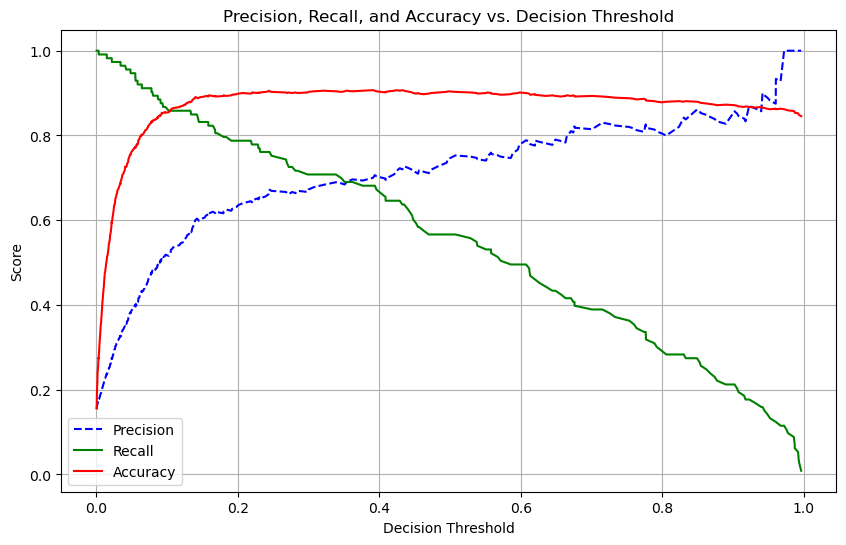

In [122]:
accuracies = []
for threshold in thresholds:
    # Apply threshold to positive class probabilities to create new predictions
    y_pred_threshold = (y_scores > threshold).astype(int)

    # Calculate confusion matrix and extract TP, TN, FP, FN
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_threshold).ravel()

    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    accuracies.append(accuracy)

# Plotting precision, recall, and accuracy
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, accuracies, "r-", label="Accuracy")
plt.title("Precision, Recall, and Accuracy vs. Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [123]:
precisions = precisions[:-1]
recalls = recalls[:-1]

closest_index = np.argmin(np.abs(precisions - recalls))
intersection_threshold = thresholds[closest_index]
intersection_precision = precisions[closest_index]
intersection_recall = recalls[closest_index]

print(f"Threshold at Intersection: {intersection_threshold}")
print(f"Precision at Intersection: {intersection_precision}")
print(f"Recall at Intersection: {intersection_recall}")

Threshold at Intersection: 0.35363548935105826
Precision at Intersection: 0.6902654867256637
Recall at Intersection: 0.6902654867256637


**_We Will Now Go Ahead And Train Our Model On The Train And Validation Set. Then We Will Apply Those Thresholds To Our Predictions And Evaluate Our Performance_**


In [ ]:
y_val_probabilities = ebm_reduced_tuned.predict_proba(X_val_reduced)[:, 1]


threshold = intersection_threshold
y_pred_custom_threshold = (y_val_probabilities > threshold).astype(int)

In [ ]:
print(classification_report(y_val, y_pred_custom_threshold))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       618
           1       0.70      0.69      0.69       113

    accuracy                           0.91       731
   macro avg       0.82      0.82      0.82       731
weighted avg       0.91      0.91      0.91       731



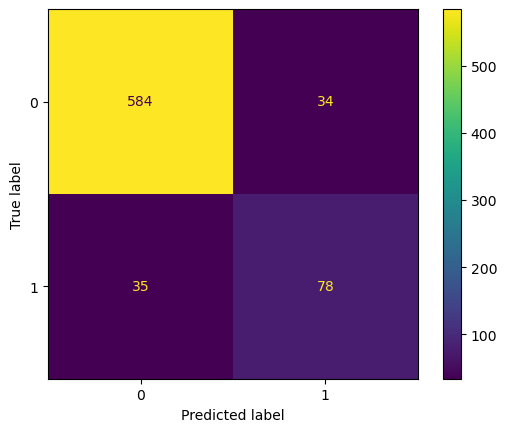

In [ ]:
cm = confusion_matrix(y_val, y_pred_custom_threshold, labels=ebm_reduced_tuned.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=ebm_reduced_tuned.classes_
)
disp.plot()
plt.show()

In [119]:
# Reducing Our Train_Vals Set
X_train_val_reduced = pd.concat([X_train_reduced, X_val_reduced], ignore_index=True)
y_train_val_concat = pd.concat([y_train, y_val], ignore_index=True)
X_test_reduced = X_test[top_36_features]

In [120]:
# Training Our Model On The Entire Training Set Which Includes Our Train And Val Sets.
ebm_reduced_tuned.fit(X_train_val_reduced, y_train_val_concat)

ExplainableBoostingClassifier(interactions=12, learning_rate=0.043,
                              max_bins=223, max_interaction_bins=12,
                              min_samples_leaf=7)

In [124]:
y_pred_probabilities = ebm_reduced_tuned.predict_proba(X_test_reduced)[:, 1]


threshold = intersection_threshold
y_pred_custom_threshold = (y_pred_probabilities > threshold).astype(int)

### Model Evaluation And Thoughts And Presentation

---


In [125]:
print(classification_report(y_test, y_pred_custom_threshold))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      8235
           1       0.65      0.69      0.67      1504

    accuracy                           0.89      9739
   macro avg       0.80      0.81      0.80      9739
weighted avg       0.90      0.89      0.90      9739



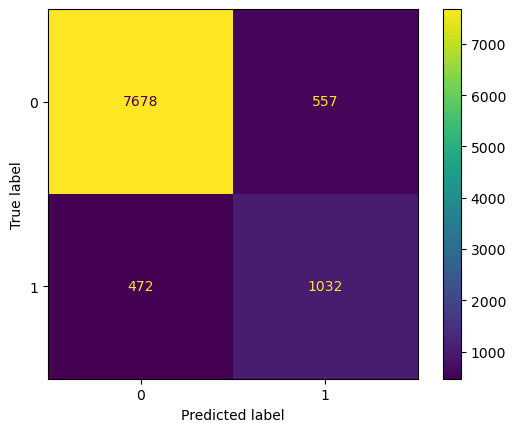

In [ ]:
cm = confusion_matrix(
    y_test, y_pred_custom_threshold, labels=ebm_reduced_tuned.classes_
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=ebm_reduced_tuned.classes_
)
disp.plot()
plt.show()

- We Have An Overall Accuracy Of About 90% (Dosen't Say A Whole Lot, Only That Out Of Our Entire Data We Got 90% Correct. Because Our Data Had 85% Of Class 0, This Dosen's Say Much)
- Our Recall Was Slightly better than our Precision at 70% (Out Of 1504 True Positives We Classified 1052 Correct!)
- Our Precision Was Slightly Lower At 64% (Out Of 8235 Sessions That Didnt End In Revenue We Misclassified 601 Of Them.)

- Our Model Isn't The Best at Predicting If A Seission Will End In Revenue. However, It's Very Good At Predicting Sessions That WONT End In Revenue. This Means That Our Models Could Be Used To Target Those Sessions With Better Offers Or Other Relevant Strategies And Focus On Getting This Group To Actually Convert. We Are Also Quite Good At Predicting Alot Of The True Positives As Positives So This Is Still Very Valuable Even If Me Myself Would Have Preferred It To Be Even Higher.

---

## Let's Look At How Our Models Made Some Of It's Predictions (Theese Are Without The Custom Threshold We Used. I Wasnt Able To Plot Those But We Are Able To Impelemnt Them In Our Model. )


In [126]:
show(ebm_reduced_tuned.explain_local(X_test_reduced[0:20], y_test[0:20]), 0)

<!-- http://127.0.0.1:7001/2565386888528/ -->

In [127]:
show(ebm_reduced_tuned.explain_local(X_test_reduced[70:90], y_test[70:90]), 0)

<!-- http://127.0.0.1:7001/2565384832080/ -->

Theese 2 Samples From Above Shows Why It Can Be So Difficult To Predict This. The First Sample Has Most Of The Important Features And Values That Should Lead To Revenue But Still Diidn't. The Second Sample Is The Complete Opposite. One Thing CocoBananas Could Do Is Poll Their Visitiors Maybe, Try To Get A Better Understanding Of Why The Ones Who Didn't Make A Transaction Even Though The Model Was Fairly Certain That They Would. Ofcourse Human Behaviour Can Sometimes Be Unpredictable, Havent We All Been On An Online Shop And Then In The Last Second Before Checkout We Just Close The Page And Dont Commit?

Overall, With The Data We Have, It Would Be Hard To Make Live Predictions Mostly Because While Its Live We Wont Have Informatin Like How Many Pages They Will End Up Visiting, Or What Hours They Are Visiting. A Few Other Things That Maybe Could Have Made The Model Slightly Better Is If The Data Was Properly Gathered And Not As Dirty As This Was. Maybe With Some Better Explanations From The CEO About The Data. Without A Domain Expert THis Became Harder Especially Since We Dont Know What Everything Is.

For The Future, CocoBananas Should Maybe Gather Data In A More Reliable Way. We Have Lot Of Missing Data That We Had To Fill In Which Could Have Affected The Model Negatively. If Possible Maybe Name The Browsers, Regions, And Other Categorical Columns That Were Numbered. The Column PageValues Correlation With Revenue Is Worrysome, Our Model Depends Alot On This. I Would Have Preffered If The Value That Came From Revenue Had It's Own Column So That We Could Remove That. This Way We Have Some Data Leakage, But Without It It Would Be Extremely Difficult To Make This Kind Of PRedictions With The Data That We Have. If I Had More Time I Could Have Tried Some More Feature Engineering, Used More Models To Evaluate And Hopefully Gotten A Better Result.

When Looking At Some Months That Get An Negative Impact On Our Predictions It Gives Us A Bit Insight. CocoBananas Should Focus On Targeting More People With Ads, product placement and maybe even Special Offers On The Months That Are Less Likely To Lead To Revenue. For Example, May Is Not Doing Well Compared To November.

We Need Customers To Get To Certain Pages That The Model Prioritizes To Increase Sessions That Lead To Revenue. If We Had Data On Which Theese Pages Were Then It Could Possibly Have Made It Better For The Model To Find More Trends In The Data To Make It More Accurate, And Tell Us More About The User's Behaviour.

One Last Observation Is That A Special Day Didnt Make A Huge Difference For Our Model. And By Looking At The Number Of Session That Actually Led To A Transaction It Seems Like CocoBananas Isnt Doing Much To Target Their Customers During Theese Special Days. They Need To Drive More Traffic And also Possibly Have Some Offers For The Visitors So That They Are More Inclined To Make A Transaction.
